In [ ]:
%%capture
# Installing SpeechBrain
BRANCH = 'develop'
!git clone https://github.com/speechbrain/speechbrain.git -b $BRANCH
%cd /content/speechbrain/
!python -m pip install .

In [ ]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

In [ ]:
import speechbrain as sb

source = sb.dataio.dataio.read_audio('spk1_snt1.wav').squeeze()
print(source.shape)


torch.Size([45920])


This is the imported signal:

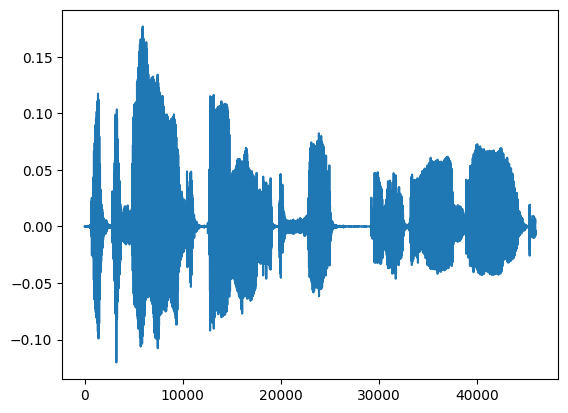

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(source)
plt.show()

from IPython.display import Audio
Audio('spk1_snt1.wav')

In [ ]:
# BE CAREFUL, IF YOU ARE NOT CONNECTED TO A GPU RUNTIME, THIS WILL CRASH
# THis only happens on Colab, you can of course load models on
from speechbrain.lobes.models.huggingface_transformers.wav2vec2 import Wav2Vec2
from speechbrain.lobes.models.huggingface_transformers.whisper import Whisper

# HuggingFace model hub
model_hub_w2v2 = "facebook/wav2vec2-base-960h"
model_hub_whisper = "openai/whisper-tiny"

model_w2v2 = Wav2Vec2(model_hub_w2v2, save_path='/content/pretrained/')
model_whisper = Whisper(model_hub_whisper, save_path='/content/pretrained/')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

Here, we can explore the model ...

In [ ]:
print(model_w2v2)

Wav2Vec2(
  (model): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Wav2Vec

Now, we can try to extract audio features from those models! In our examples however, we have two different models that require different forward operations if our goal **solely is to retrieve the latent representation of the audio input.** Wav2vec 2.0 is a transformer encoder, so we just need to get the output of the last layer. Whisper, on the other end, is packaged as a fully trained encoder-decoder. **Hence, we must make sure that we only retrieve the output of the encoder!**

In [ ]:
source = source.unsqueeze(0)
print(source.shape)

fea_w2v2 = model_w2v2(source)
print(fea_w2v2.shape)

# This can be given as an argument when we instantiate the model as well
model_whisper.encoder_only=True
fea_whisper = model_whisper(source)
print(fea_whisper.shape)

torch.Size([1, 45920])
torch.Size([1, 143, 768])
torch.Size([1, 1500, 384])


In [ ]:
from sklearn.manifold import TSNE

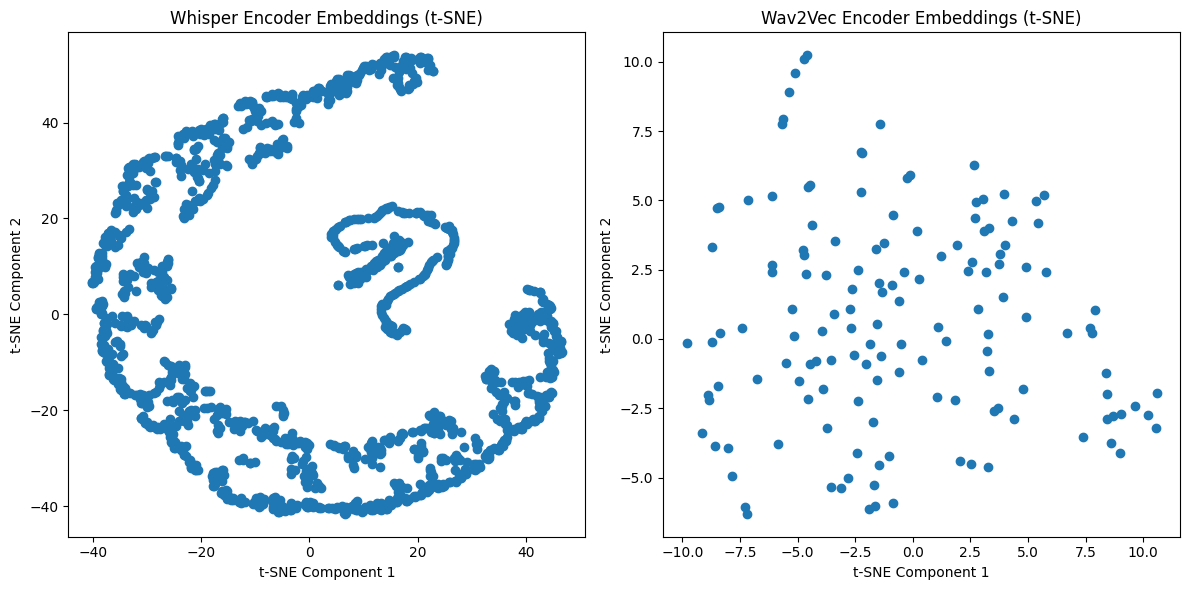

In [ ]:
tsne = TSNE(n_components=2)

# Reduce dimensions for Whisper encoder
whisper_features_tsne = tsne.fit_transform(fea_whisper.squeeze(0).detach().numpy())

# Reduce dimensions for Wav2Vec encoder
wav2vec_features_tsne = tsne.fit_transform(fea_w2v2.squeeze(0).detach().numpy())

# Plot embeddings
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(whisper_features_tsne[:, 0], whisper_features_tsne[:, 1])
plt.title('Whisper Encoder Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.subplot(1, 2, 2)
plt.scatter(wav2vec_features_tsne[:, 0], wav2vec_features_tsne[:, 1])
plt.title('Wav2Vec Encoder Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()